In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict
import itertools
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from IPython.display import display, Markdown, Latex
from tqdm import tnrange

import torch
from torch import nn
import torch.nn.functional as F

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [4]:
torch.manual_seed(33)

In [5]:
from simple_relational_reasoning.datagen import *
from simple_relational_reasoning.datagen import object_gen
from simple_relational_reasoning.models import MLPModel, RelationNetModel

import run
from defaults import FIELD_CONFIGURATIONS

In [6]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight'):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        print('Figure:\n')
        print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('\nWrapfigure:\n')
        print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [7]:
from collections import namedtuple
VisualizationDefinition = namedtuple('VisualizationDefinition', ('name', 'patch_class', 'offset', 'patch_args'))
VISUALIZATION_DEFINITIONS = (
    VisualizationDefinition('square', mpatches.Rectangle, np.array([0, 0]), (10, 10)),
    VisualizationDefinition('circle', mpatches.Ellipse, np.array([5, 5]), (10, 10)),
    VisualizationDefinition('triangle', mpatches.RegularPolygon, np.array([5, 5]), (3, 6)),
    VisualizationDefinition('pentagon', mpatches.RegularPolygon, np.array([5, 5]), (5, 5.5)),
)


DEFAULT_PATCH_KWARGS = dict(ec='none')
DEFAULT_SCALE = 10


def object_to_patch(object_tensor, field_slices, 
                    x_field='x', y_field='y', 
                    x_length_field='x_len', y_length_field='y_len',
                    color_field='color', shape_field='shape',
                    scale=DEFAULT_SCALE, additional_patch_kwargs=None, 
                    visualization_definitions=VISUALIZATION_DEFINITIONS):
    
    patch_kwargs = DEFAULT_PATCH_KWARGS.copy()
    if additional_patch_kwargs is not None: 
        patch_kwargs.update(additional_patch_kwargs)
    
    x = int(object_tensor[field_slices[x_field]])
    y = int(object_tensor[field_slices[y_field]])
    position = np.array([x, y]) * scale
    
    shape_index = 0
    if shape_field in field_slices:
        shape_index = int(torch.nonzero(object_tensor[field_slices[shape_field]]).squeeze())
        
    color_index = 0
    if color_field in field_slices:
        color_index = int(torch.nonzero(object_tensor[field_slices[color_field]]).squeeze())
        
    
    vis_def = visualization_definitions[shape_index]
    offset = vis_def.offset
    patch_args = vis_def.patch_args
    
    x_len = 1
    if x_length_field in field_slices:
        x_len = object_tensor[field_slices[x_length_field]]
        
    y_len = 1
    if y_length_field in field_slices:
        y_len = object_tensor[field_slices[y_length_field]]
        
    offset = np.multiply(offset, np.array([x_len, y_len]))
    patch_args = [patch_args[0] * x_len, patch_args[1] * y_len] + list(patch_args[2:])
    
    patch = vis_def.patch_class(position + offset, *patch_args, **patch_kwargs)
    
    return patch, color_index


def create_patches_and_colors(objects, object_generator, ax=None, x_field='x',
                      y_field='y', color_field='color', shape_field='shape',
                      scale=DEFAULT_SCALE, figsize=(6, 6), bg_color='black', 
                      additional_patch_kwargs=None, 
                      visualization_definitions=VISUALIZATION_DEFINITIONS,
                      cmap=plt.cm.tab10, clim=(0, 10)):
    
    patches, colors = zip(*[object_to_patch(objects[i], object_generator.field_slices, 
                                            x_field=x_field, y_field=y_field, 
                                            color_field=color_field, shape_field=shape_field, 
                                            scale=scale, additional_patch_kwargs=additional_patch_kwargs,
                                            visualization_definitions=visualization_definitions)
                            for i in range(objects.shape[0])])
    
    return patches, colors


def visualize_objects(objects, object_generator, ax=None, x_field='x',
                      y_field='y', color_field='color', shape_field='shape',
                      scale=DEFAULT_SCALE, figsize=(6, 6), bg_color='black', 
                      additional_patch_kwargs=None, 
                      visualization_definitions=VISUALIZATION_DEFINITIONS,
                      cmap=plt.cm.tab10, clim=(0, 10)):
   
    call_show = False
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        call_show = True

    x_gen = object_generator.field_generators[x_field]
    plt.xlim(x_gen.min_coord * scale, x_gen.max_coord * scale)
    y_gen = object_generator.field_generators[y_field]
    plt.ylim(y_gen.min_coord * scale, y_gen.max_coord * scale)
    ax.set_facecolor(bg_color)
    
    patches, colors = create_patches_and_colors(
        objects=objects, object_generator=object_generator, ax=ax, x_field=x_field,
        y_field=y_field, color_field=color_field, shape_field=shape_field,
        scale=scale, additional_patch_kwargs=additional_patch_kwargs,
        visualization_definitions=visualization_definitions
    )
    
    collection = PatchCollection(patches, cmap=cmap) 
    collection.set_array(np.array(colors)) 
    
    if bg_color == 'black':
        collection.set_edgecolor('white')
    else:
        collection.set_edgecolor('black')
    collection.set_clim(*clim)
    ax.add_collection(collection)
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    if call_show:
        plt.show()
    

------
------

# Inductive Bias Paradigm

In [8]:
QUINN_FIELD_CONFIG_WITH_SIZE = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=25)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=25)),
    object_gen.FieldConfig('x_len', 'int_position', dict(min_coord=1, max_coord=10)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
)
QUINN_FAUX_GENERATOR_WITH_SIZE = ObjectGenerator(1, QUINN_FIELD_CONFIG_WITH_SIZE, BetweenRelation)

QUINN_FIELD_CONFIG_WITHOUT_SIZE = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=25)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=25)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
)

QUINN_FAUX_GENERATOR_WITHOUT_SIZE = ObjectGenerator(1, QUINN_FIELD_CONFIG_WITHOUT_SIZE, BetweenRelation)

FAUX_GENERATORS = {
    ObjectGeneratorWithoutSize: QUINN_FAUX_GENERATOR_WITHOUT_SIZE,
    ObjectGeneratorWithSize: QUINN_FAUX_GENERATOR_WITH_SIZE
}

In [17]:
EXAMPLES_PER_CLASS = 3

NAMES = {
    AboveBelowReferenceInductiveBias: 'above vs. below',
    BetweenReferenceInductiveBias: 'above vs. below vs. between',
    ObjectGeneratorWithoutSize: 'objects without size',
    ObjectGeneratorWithSize: 'objects with size'
}


def plot_single_dataset(dataset, indices, faux_generators=FAUX_GENERATORS):
    label_arr = np.array(dataset.labels)
    unique_labels, unique_counts = np.unique(label_arr, return_counts=True)
    
    n_labels = len(unique_labels)
    n_panels = n_labels * EXAMPLES_PER_CLASS
    plt.figure(figsize=(4.5 * n_panels, 4))
    plt.suptitle(title.title())

    for l_i, label in enumerate(unique_labels):
        if label not in indices:
            indices[label] = np.random.permutation(np.argwhere(label_arr == label))[:EXAMPLES_PER_CLASS].squeeze()

        for ex_i, ex in enumerate(indices[label]):
            ax = plt.subplot(1, n_panels, 1 + (l_i * EXAMPLES_PER_CLASS) + ex_i)
            ax.set_title(f'C = {label} (#{ex})')
            visualize_objects(dataset[ex][0], FAUX_GENERATORS[generator_class], ax=ax)
            
    plt.show()



## above vs. below using objects without size

Of the reference object locations, train: 273, test: 31 

Training set size: 3439 | Validation set size: 383 | Test set without middle: 1650 | Middle set size: 5472

Class balance in the training set: 0: 1722 | 1: 1717

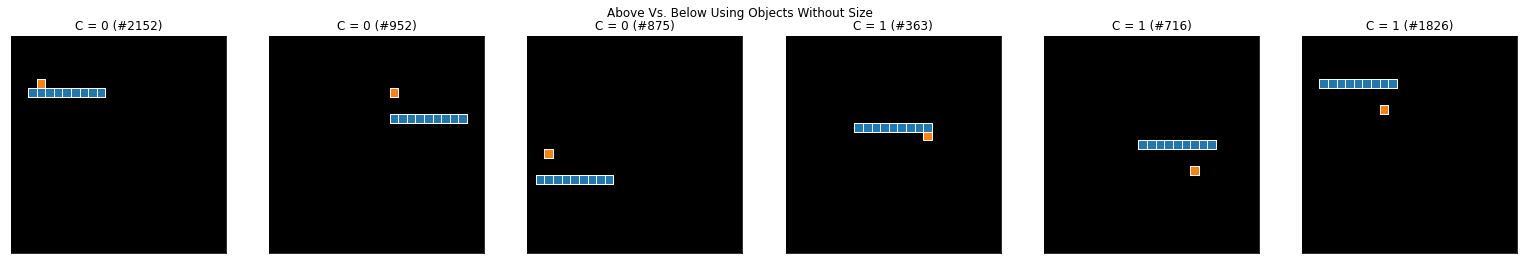

### train_reference_test_target

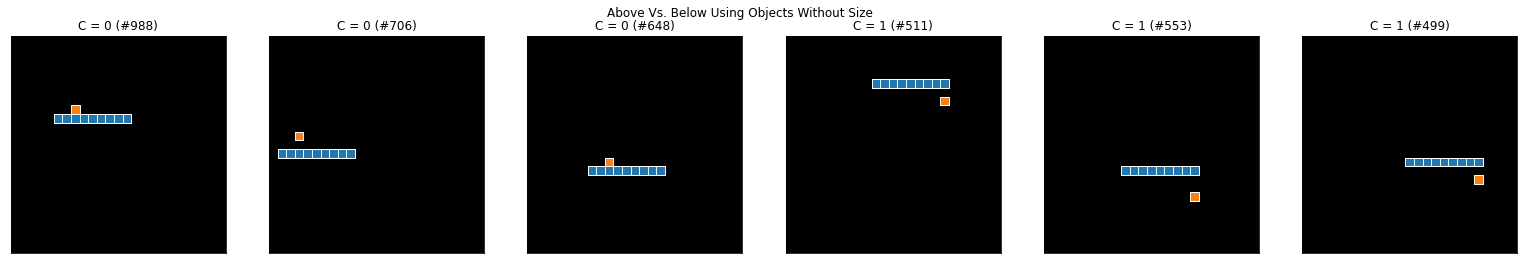

### train_reference_middle_target

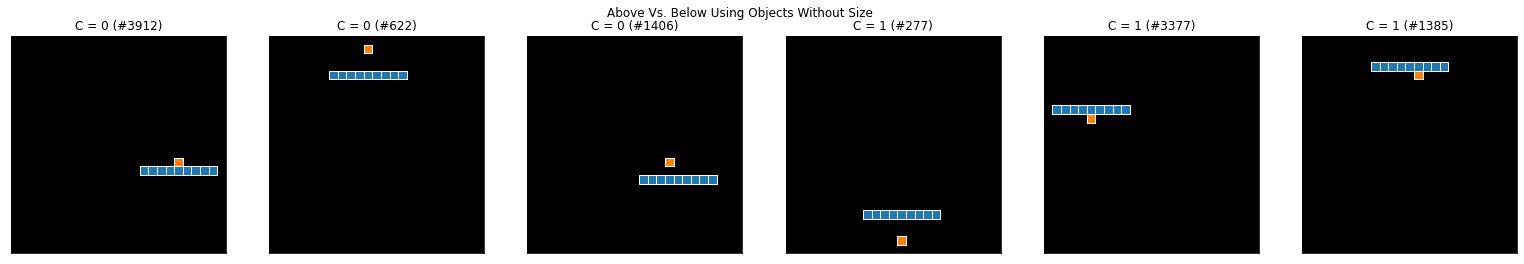

### test_reference_train_target

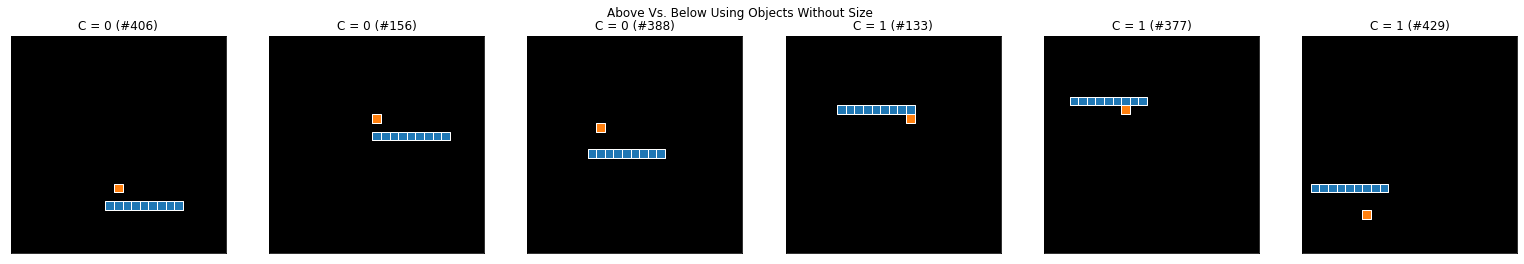

### test_reference_test_target

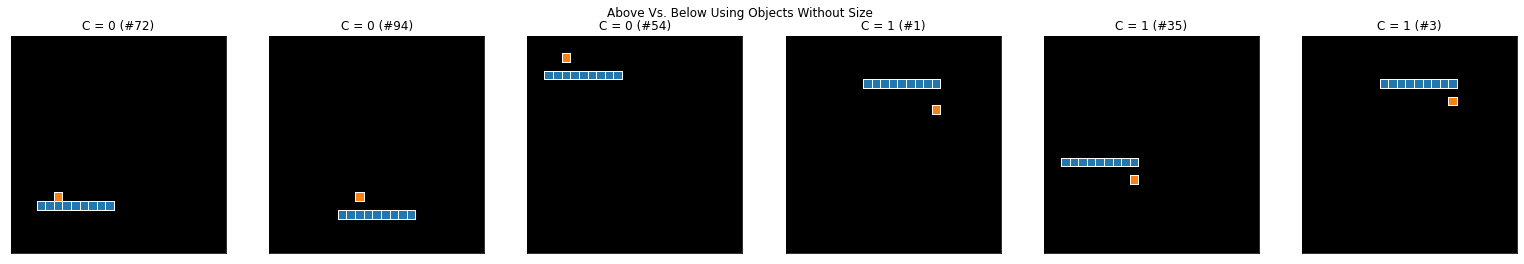

### test_reference_middle_target

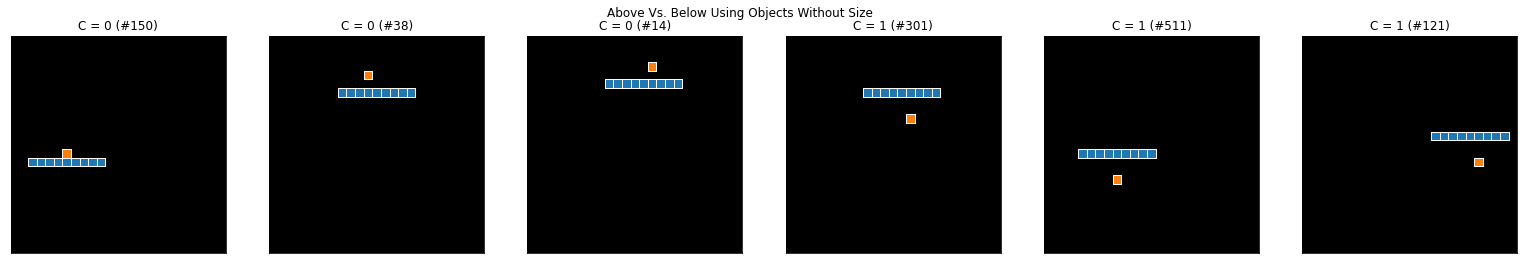

-----

-----

## above vs. below using objects with size

Of the reference object locations, train: 273, test: 31 

Training set size: 3439 | Validation set size: 383 | Test set without middle: 1650 | Middle set size: 5472

Class balance in the training set: 0: 1722 | 1: 1717

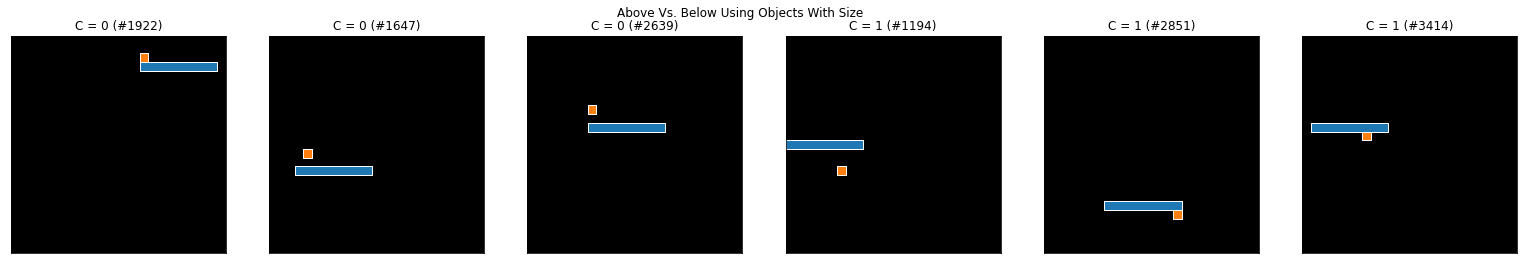

### train_reference_test_target

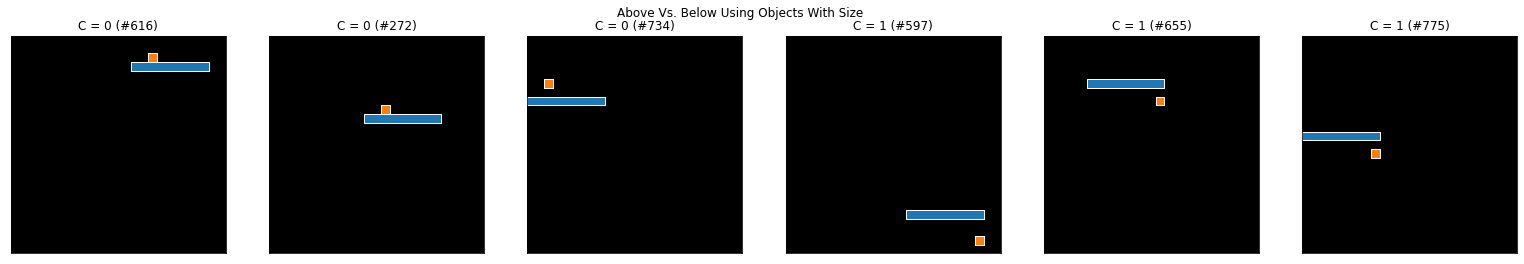

### train_reference_middle_target

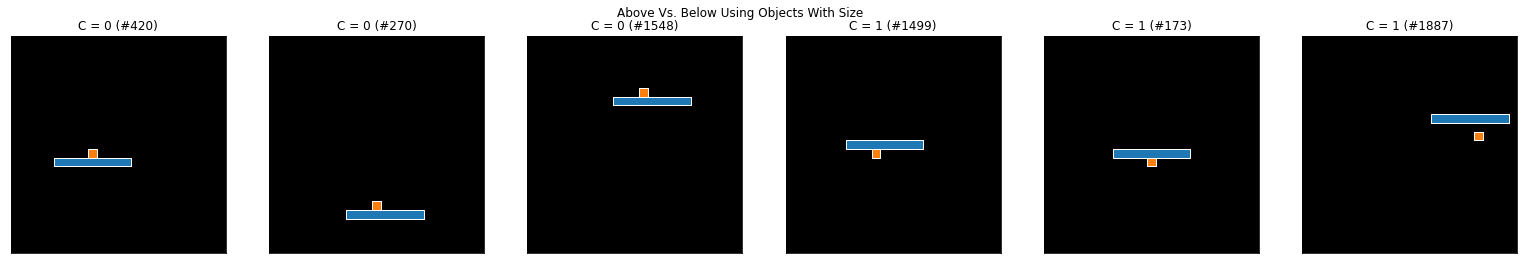

### test_reference_train_target

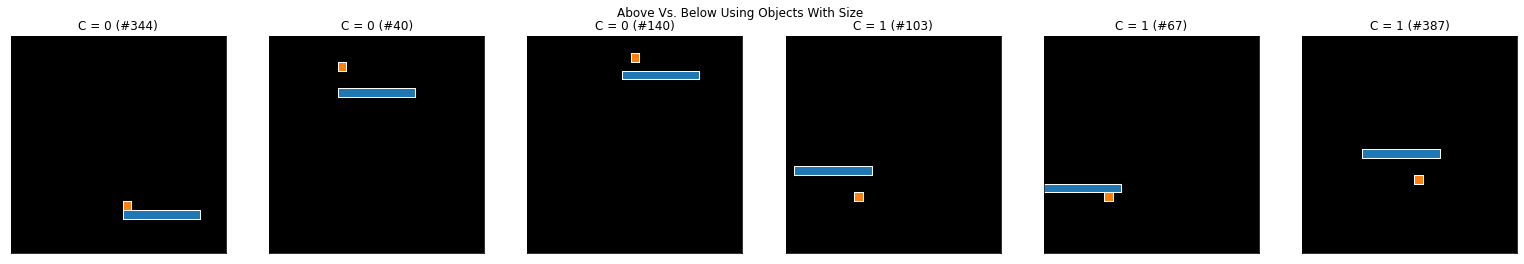

### test_reference_test_target

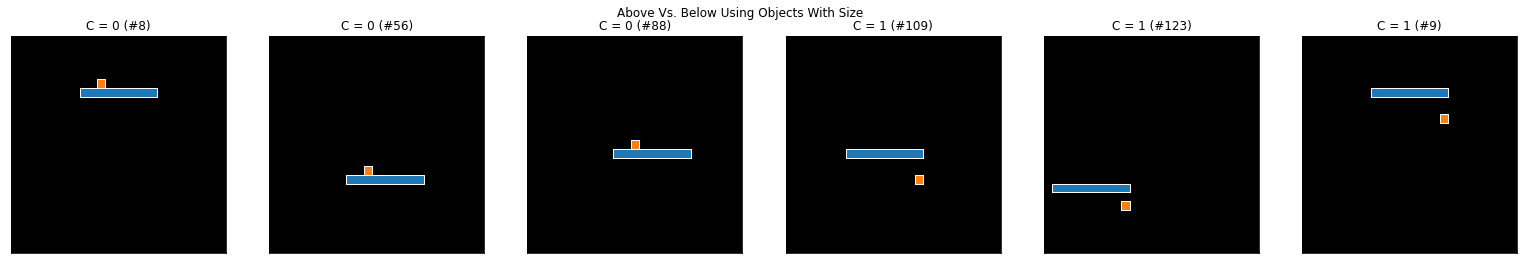

### test_reference_middle_target

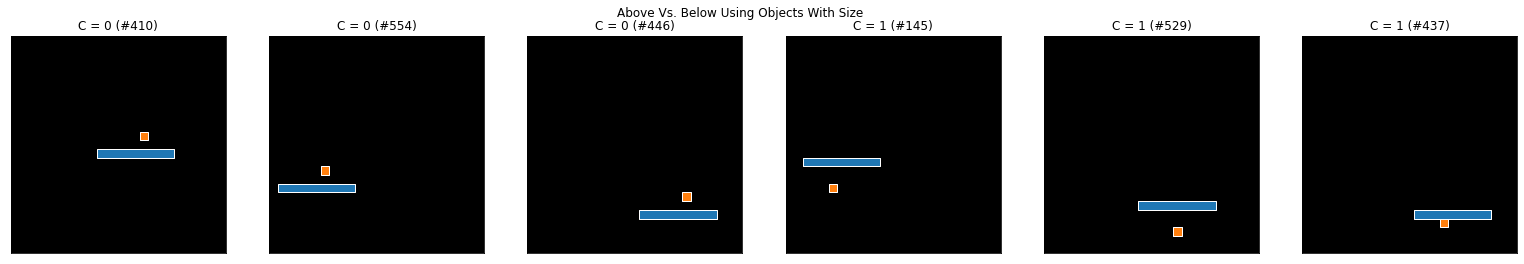

-----

-----

## above vs. below vs. between using objects without size

Of the reference object locations, train: 275, test: 31 

Training set size: 3465 | Validation set size: 385 | Test set without middle: 1658 | Middle set size: 8262

Class balance in the training set: 0: 1733 | 1: 1732

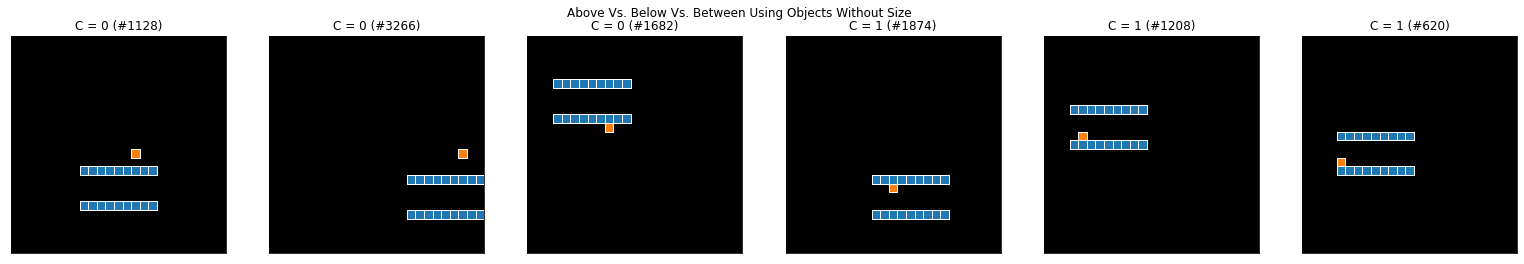

### train_reference_test_target

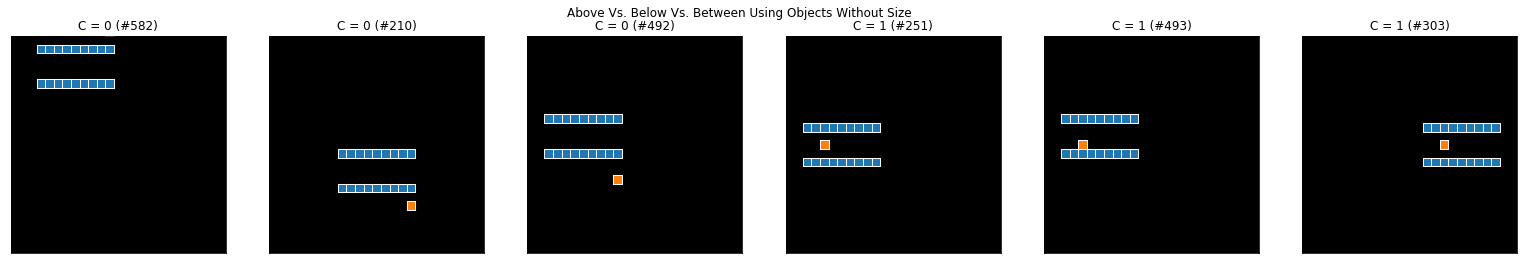

### train_reference_middle_target

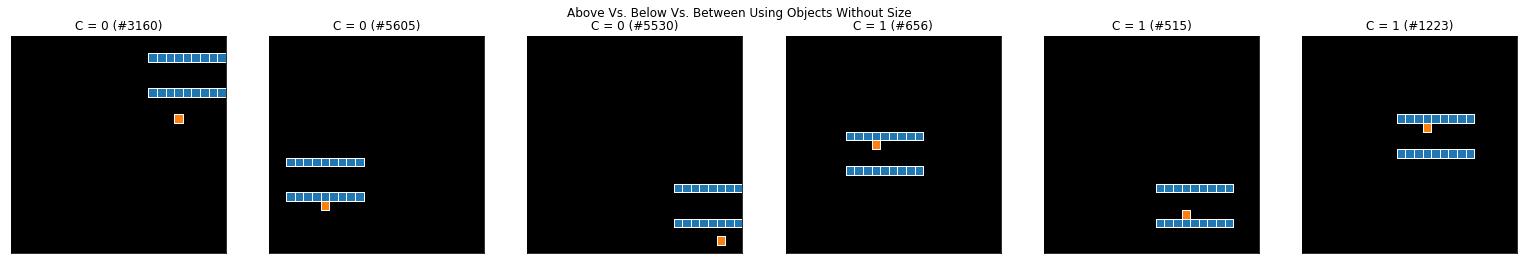

### test_reference_train_target

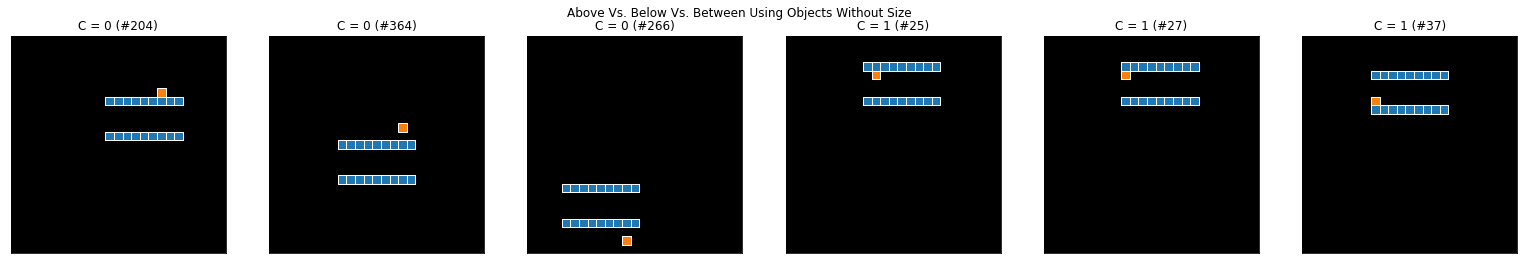

### test_reference_test_target

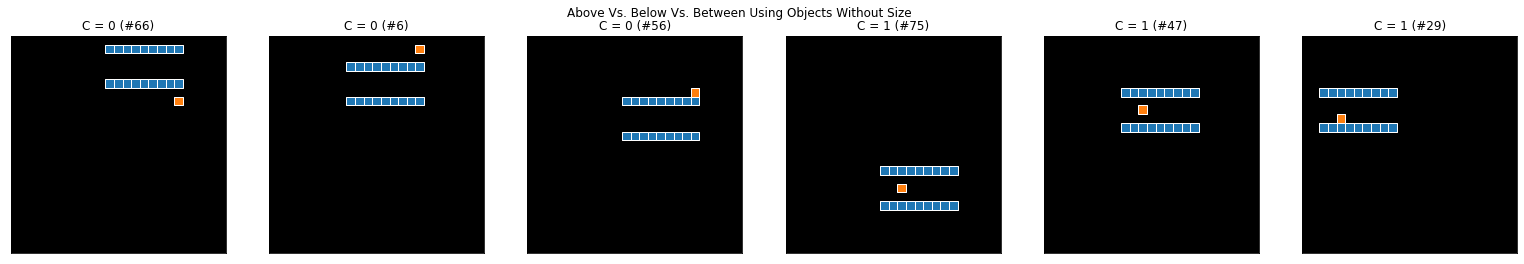

### test_reference_middle_target

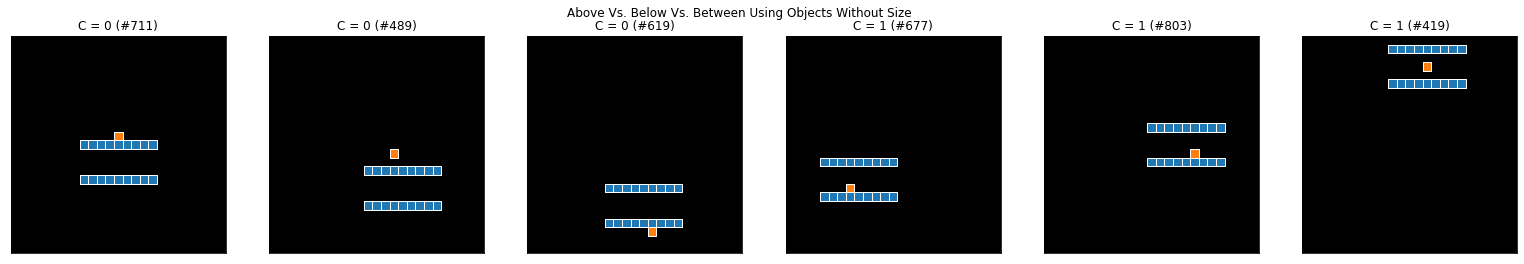

-----

-----

## above vs. below vs. between using objects with size

Of the reference object locations, train: 275, test: 31 

Training set size: 3465 | Validation set size: 385 | Test set without middle: 1658 | Middle set size: 8262

Class balance in the training set: 0: 1733 | 1: 1732

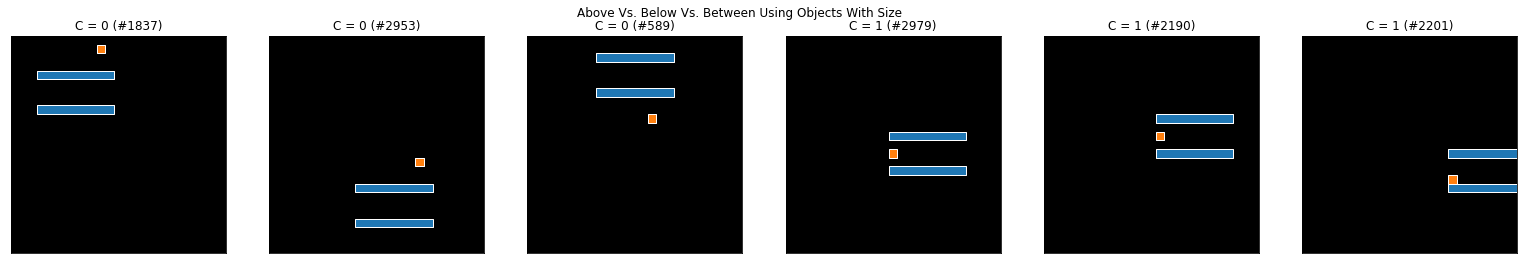

### train_reference_test_target

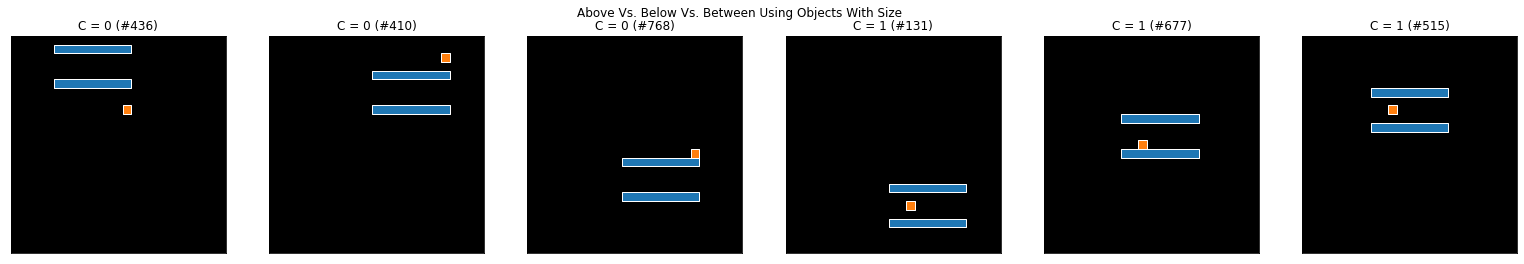

### train_reference_middle_target

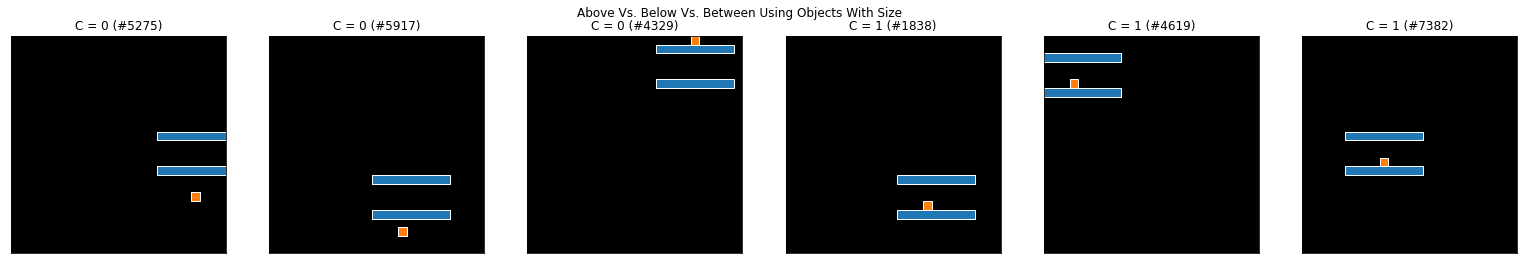

### test_reference_train_target

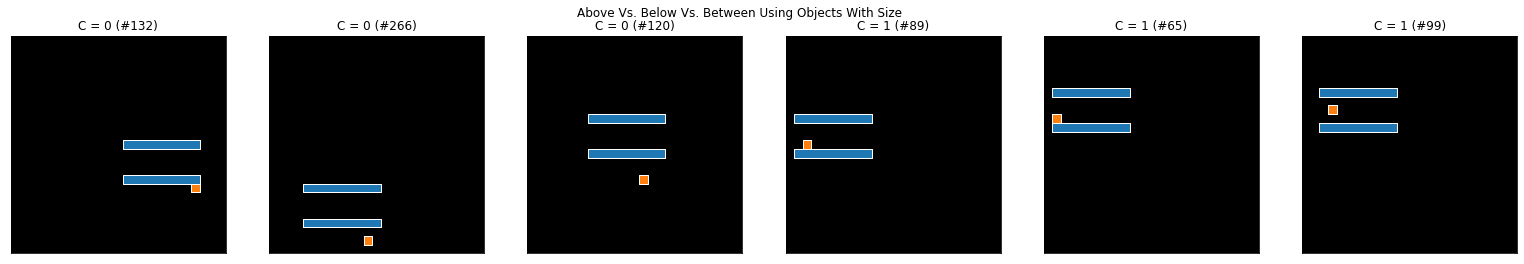

### test_reference_test_target

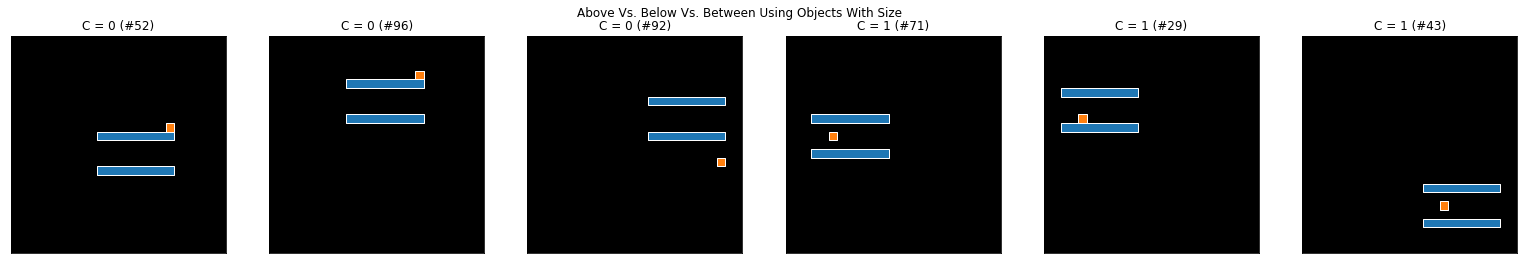

### test_reference_middle_target

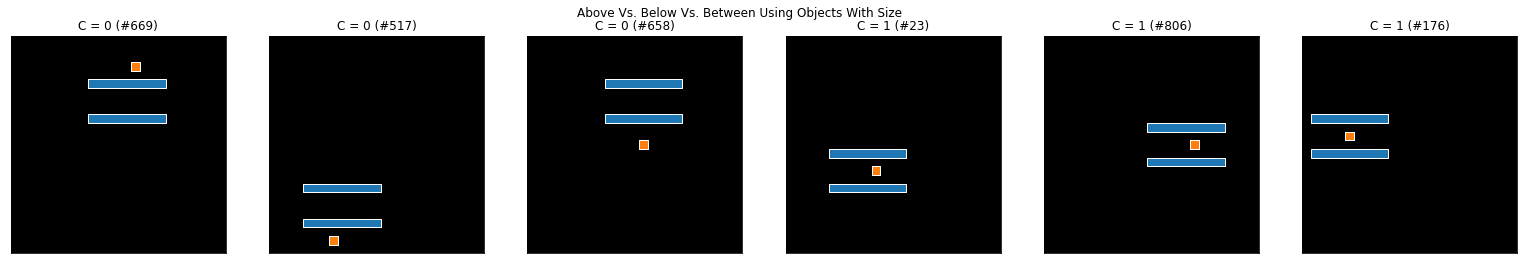

-----

-----

In [18]:
REFERENCE_OBJECT_SIZE = 9
TARGET_OBJECT_SIZE = 1
ADD_NEITHER = False
X_MAX = 25
Y_MAX = 25
BETWEEN_BONUS = 2
SEED = 33
PROP_TRAIN_REF_LOCATIONS = 0.90
N_TRAIN_TARGET_OBJECT_LOCATIONS = 7
SUBSAMPLE = 2048

DATASETS = {}

for dataset_class in (AboveBelowReferenceInductiveBias, BetweenReferenceInductiveBias):
    for generator_class in (ObjectGeneratorWithoutSize, ObjectGeneratorWithSize):
        title = f'{NAMES[dataset_class]} using {NAMES[generator_class]}'
        display(Markdown(f'## {title}'))
        gen = generator_class(SEED, REFERENCE_OBJECT_SIZE, TARGET_OBJECT_SIZE)
        between = dataset_class == BetweenReferenceInductiveBias
        dataset = dataset_class(gen, X_MAX + (int(between) * BETWEEN_BONUS), 
                                Y_MAX + + (int(between) * BETWEEN_BONUS), SEED, 
                                prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
                                n_train_target_object_locations=N_TRAIN_TARGET_OBJECT_LOCATIONS,
                                add_neither_train=ADD_NEITHER, add_neither_test=ADD_NEITHER,
                               )
#                                 subsample_train_size=SUBSAMPLE)
        
        DATASETS[(dataset_class, generator_class)] = dataset
        
        train = dataset.get_training_dataset()
        label_arr = np.array(train.labels)
        unique_labels, unique_counts = np.unique(label_arr, return_counts=True)
#         print(len(train), unique_labels, unique_counts)
        
        test_datasets = dataset.get_test_datasets()
#         print([(key, len(test_datasets[key])) for key in test_datasets])
        
        test_without_middle_size = sum([len(test_datasets[key]) for key in test_datasets if 'middle' not in key]) 
        test_middle_size = sum([len(test_datasets[key]) for key in test_datasets if 'middle' in key])
        
        display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))
        display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set without middle: {test_without_middle_size} | Middle set size: {test_middle_size}'))
        class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
        display(Markdown(f'Class balance in the training set: {class_sizes}'))
        
        train_indices = {}
        plot_single_dataset(train, train_indices)
        
        for test_set_name, test_set in test_datasets.items():
            display(Markdown(f'### {test_set_name}'))
            test_indices = {}
            plot_single_dataset(test_set, test_indices)
            
        display(Markdown('-----'))
        display(Markdown('-----'))
                                

In [10]:
dataset = list(DATASETS.values())[0]
train = dataset.get_training_dataset()
train_copy = copy.deepcopy(train)
train.subsample(dataset.rng, total=2048)
print(len(train), len(train_copy))

2048 3439


In [11]:
for i in range(len(train)):
    item, label = train[i]
    original_idx = torch.all(torch.all(item == train_copy.objects, dim=-1), dim=-1).to(torch.int).argmax()
    assert(label == train_copy.labels[original_idx])

-----

-----

# One or two reference objects paradigm

In [19]:
ONE_OR_TWO_QUINN_ABOVE_BELOW_FIELD_CONFIG_WITH_SIZE = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=18)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=18)),
    object_gen.FieldConfig('x_len', 'int_position', dict(min_coord=1, max_coord=10)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
)
ONE_OR_TWO_QUINN_ABOVE_BELOW_FAUX_GENERATOR_WITH_SIZE = ObjectGenerator(1, ONE_OR_TWO_QUINN_ABOVE_BELOW_FIELD_CONFIG_WITH_SIZE, BetweenRelation)

ONE_OR_TWO_QUINN_ABOVE_BELOW_FIELD_CONFIG_WITHOUT_SIZE = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=18)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=18)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
)

ONE_OR_TWO_QUINN_ABOVE_BELOW_FAUX_GENERATOR_WITHOUT_SIZE = ObjectGenerator(1, ONE_OR_TWO_QUINN_ABOVE_BELOW_FIELD_CONFIG_WITHOUT_SIZE, BetweenRelation)

ONE_OR_TWO_QUINN_BETWEEN_FIELD_CONFIG_WITH_SIZE = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=18)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=19)),
    object_gen.FieldConfig('x_len', 'int_position', dict(min_coord=1, max_coord=10)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
)
ONE_OR_TWO_QUINN_BETWEEN_FAUX_GENERATOR_WITH_SIZE = ObjectGenerator(1, ONE_OR_TWO_QUINN_BETWEEN_FIELD_CONFIG_WITH_SIZE, BetweenRelation)

ONE_OR_TWO_QUINN_BETWEEN_FIELD_CONFIG_WITHOUT_SIZE = (
    object_gen.FieldConfig('x', 'int_position', dict(max_coord=18)),
    object_gen.FieldConfig('y', 'int_position', dict(max_coord=19)),
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=2)),
)

ONE_OR_TWO_QUINN_BETWEEN_FAUX_GENERATOR_WITHOUT_SIZE = ObjectGenerator(1, ONE_OR_TWO_QUINN_BETWEEN_FIELD_CONFIG_WITHOUT_SIZE, BetweenRelation)

ONE_OR_TWO_QUINN_FAUX_GENERATORS = {
    False: {
        ObjectGeneratorWithoutSize: ONE_OR_TWO_QUINN_ABOVE_BELOW_FAUX_GENERATOR_WITHOUT_SIZE,
        ObjectGeneratorWithSize: ONE_OR_TWO_QUINN_ABOVE_BELOW_FAUX_GENERATOR_WITH_SIZE
    },
    True: {
        ObjectGeneratorWithoutSize: ONE_OR_TWO_QUINN_BETWEEN_FAUX_GENERATOR_WITHOUT_SIZE,
        ObjectGeneratorWithSize: ONE_OR_TWO_QUINN_BETWEEN_FAUX_GENERATOR_WITH_SIZE
    }
}

## One reference object using objects without size

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1825 | 1: 1803

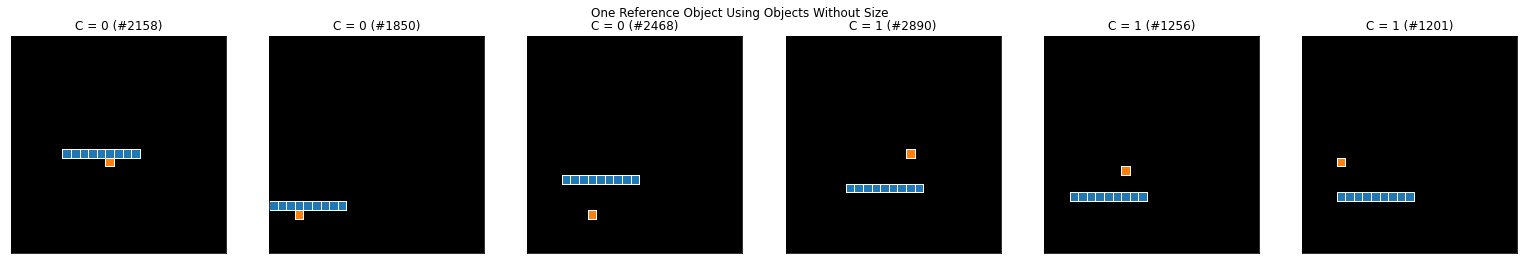

### train_reference_test_target

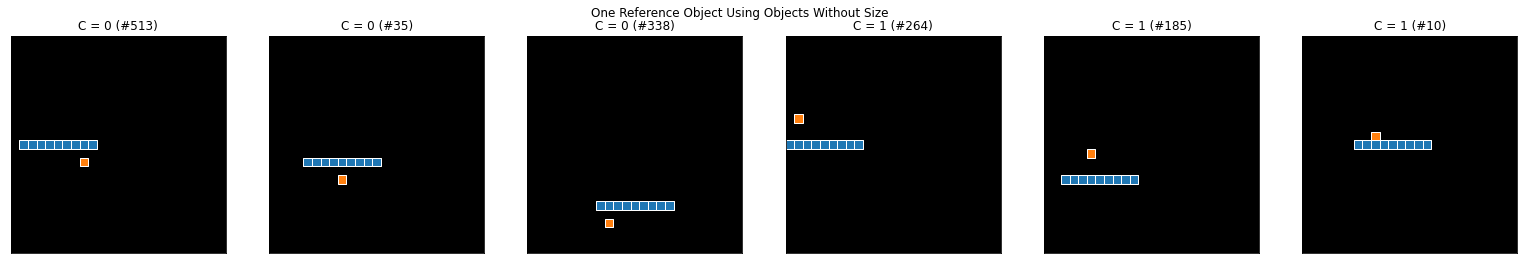

### test_reference_train_target

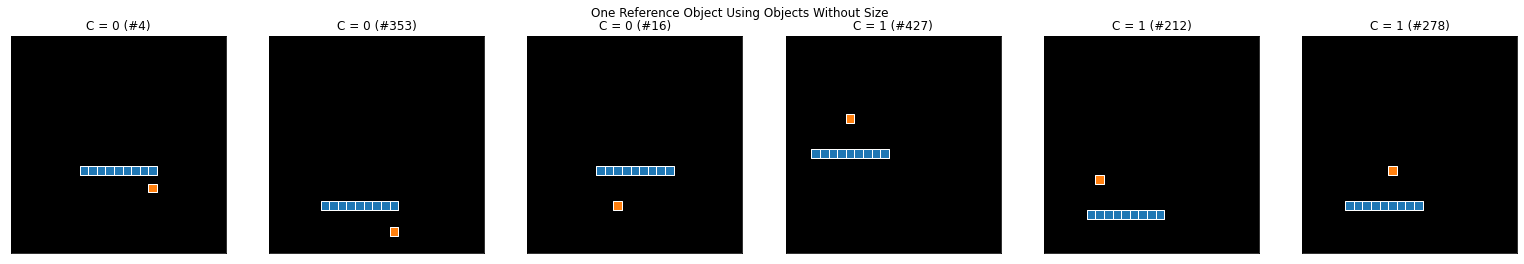

### test_reference_test_target

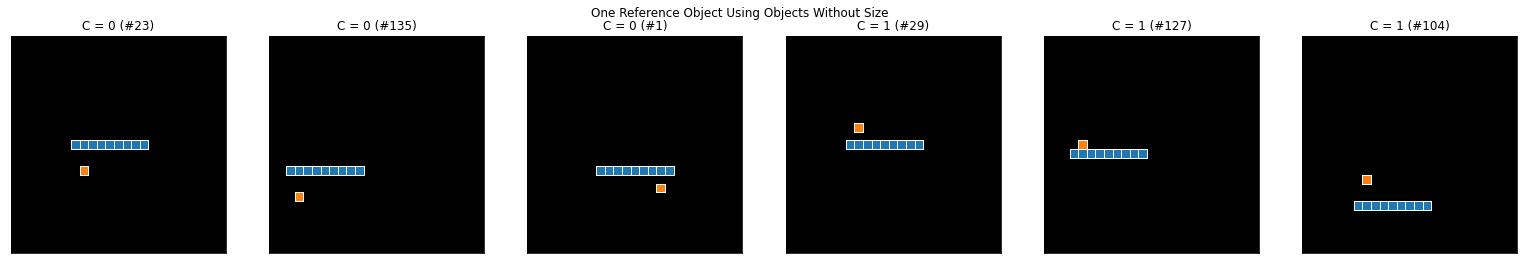

## Two reference objects using objects without size

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1819 | 1: 1809

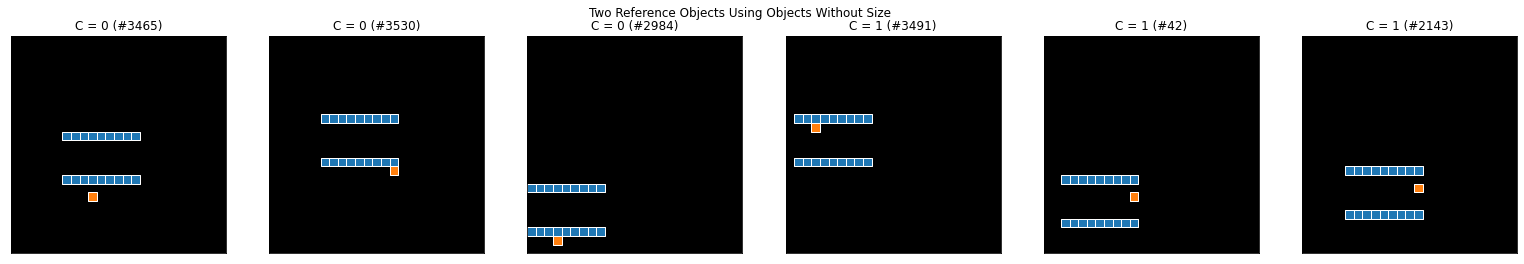

### train_reference_test_target

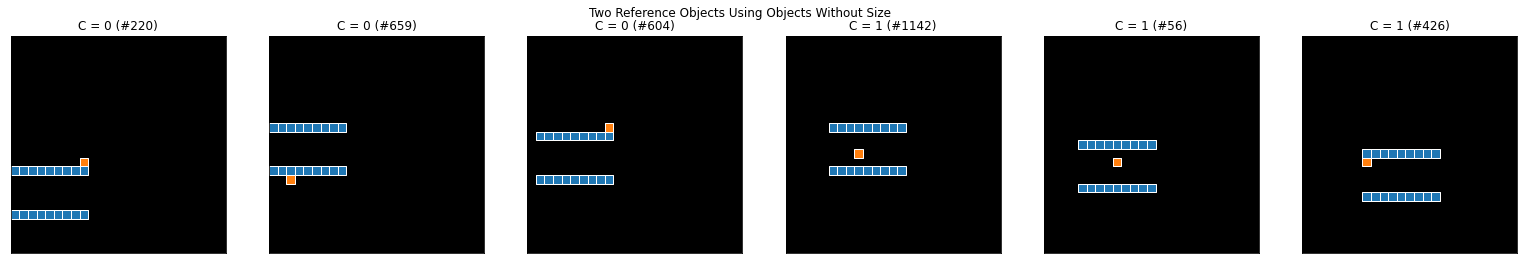

### test_reference_train_target

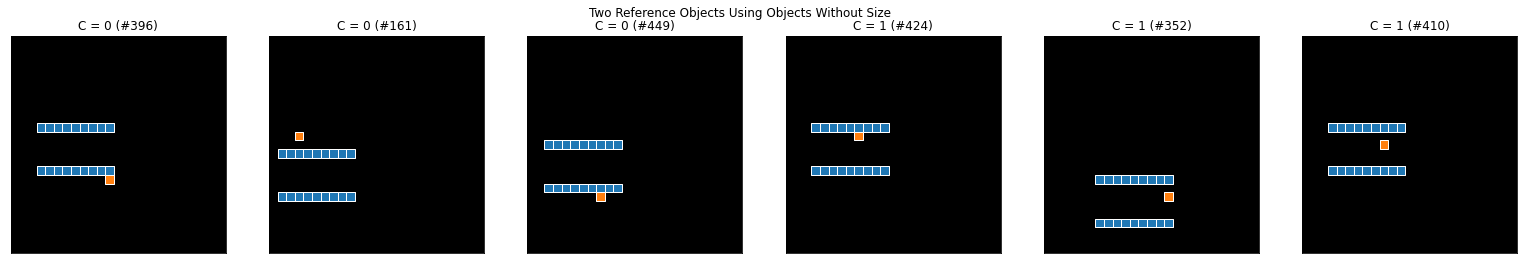

### test_reference_test_target

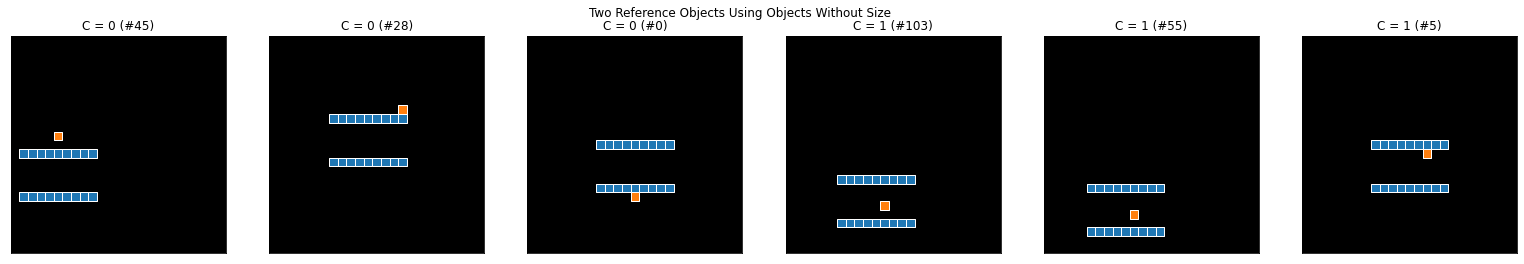

-----

-----

## One reference object using objects with size

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1825 | 1: 1803

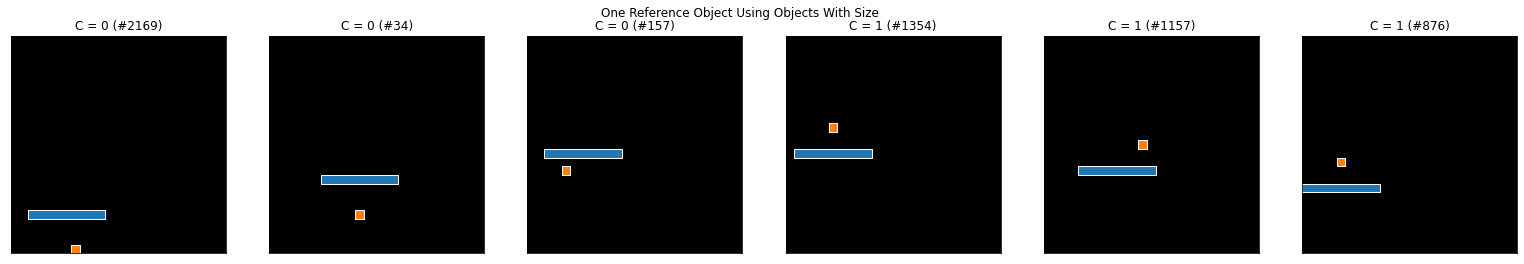

### train_reference_test_target

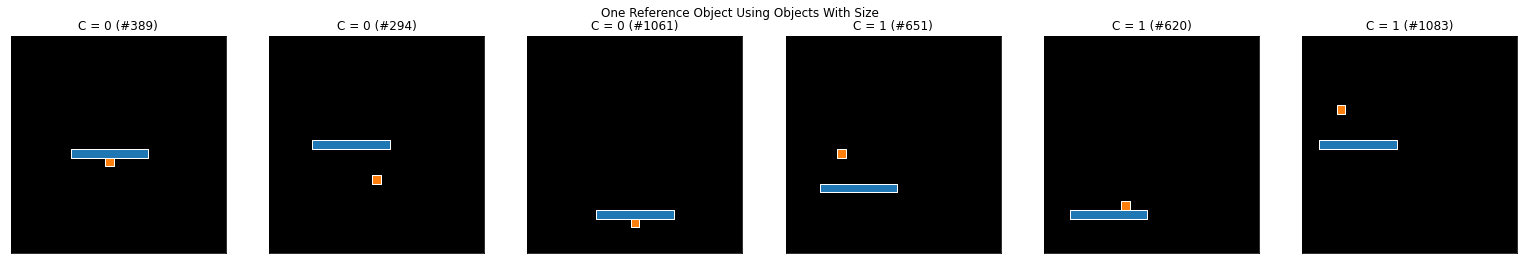

### test_reference_train_target

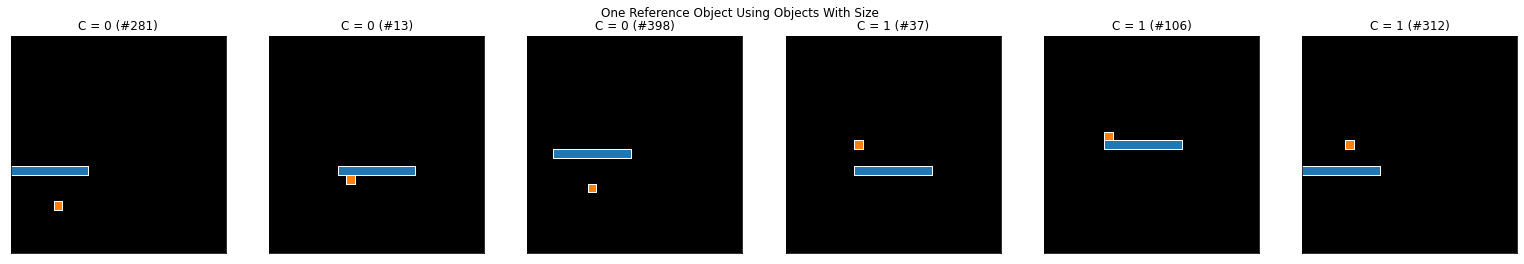

### test_reference_test_target

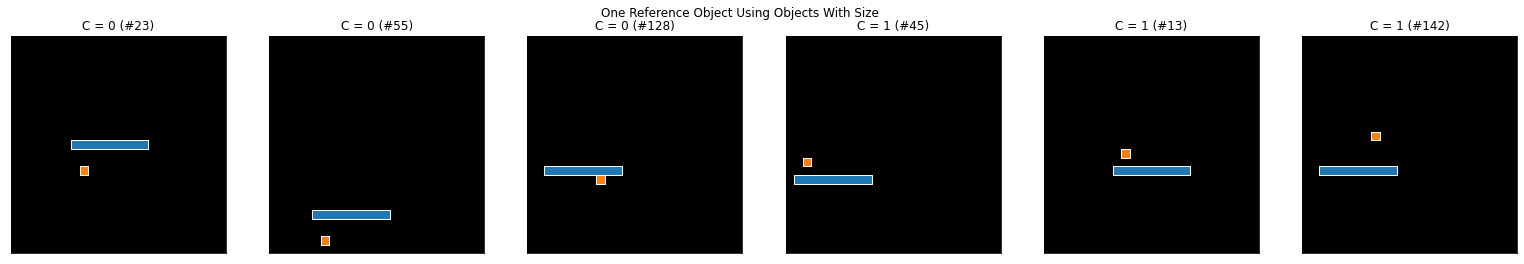

## Two reference objects using objects with size

Of the reference object locations, train: 72, test: 9 

Training set size: 3628 | Validation set size: 404 | Test set size: 1800

Class balance in the training set: 0: 1819 | 1: 1809

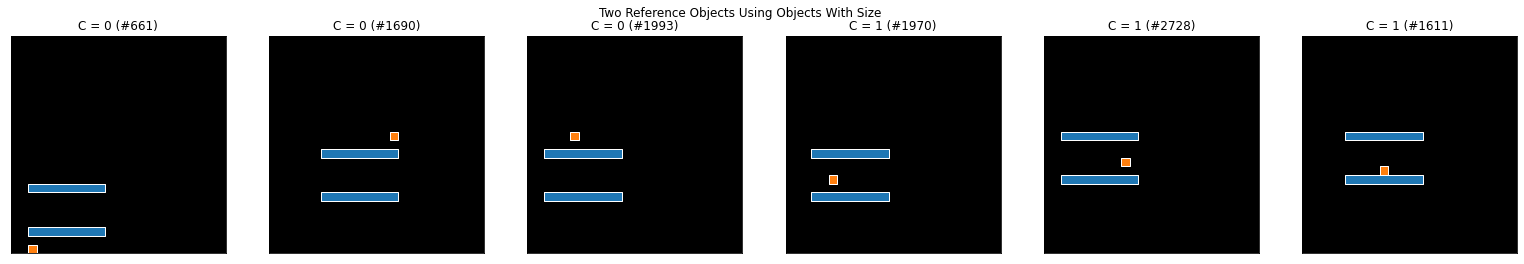

### train_reference_test_target

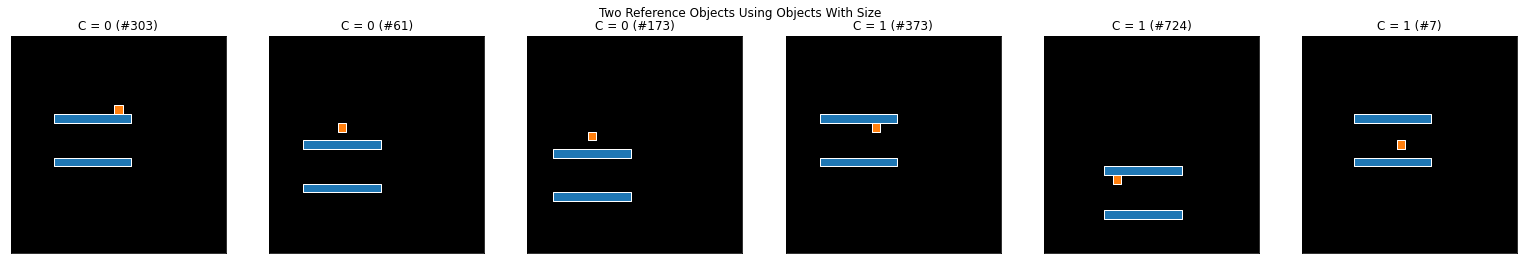

### test_reference_train_target

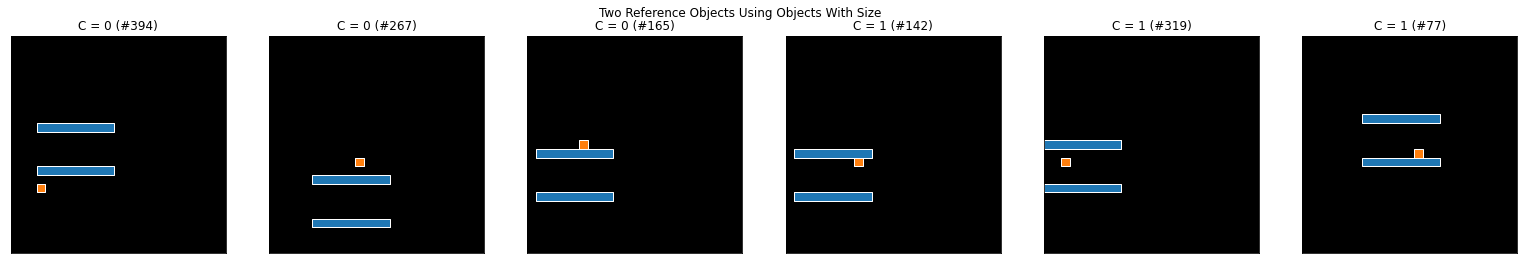

### test_reference_test_target

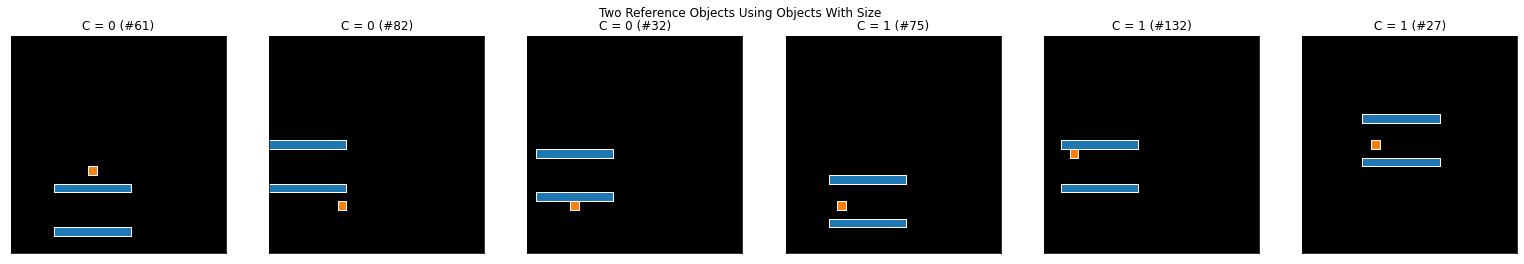

-----

-----

In [20]:
REFERENCE_OBJECT_SIZE = 9
TARGET_OBJECT_SIZE = 1
ADD_NEITHER = False
X_MAX = 18
Y_MAX = 18
SEED = 33
EXAMPLES_PER_CLASS = 3
PROP_TRAIN_REF_LOCATIONS = 0.90
PROP_TRAIN_TARGET_LOCATIONS = 0.8
SUBSAMPLE = None

indices = {}

ONE_OR_TWO_DATASETS = {}
    

for generator_class in (ObjectGeneratorWithoutSize, ObjectGeneratorWithSize):
    for two_reference_objects in (False, True):
        title = f'{two_reference_objects and "Two reference objects" or "One reference object"} using {NAMES[generator_class]}'
        display(Markdown(f'## {title}'))
        gen = generator_class(SEED, REFERENCE_OBJECT_SIZE, TARGET_OBJECT_SIZE)
        dataset = OneOrTwoReferenceObjects(gen, X_MAX, Y_MAX + int(two_reference_objects), SEED, two_reference_objects=two_reference_objects,
                                           between_relation=two_reference_objects,
                                           prop_train_reference_object_locations=PROP_TRAIN_REF_LOCATIONS,
                                           prop_train_target_object_locations=PROP_TRAIN_TARGET_LOCATIONS,
                                           add_neither_train=ADD_NEITHER, add_neither_test=ADD_NEITHER,
                                           subsample_train_size=SUBSAMPLE)
        
        ONE_OR_TWO_DATASETS[generator_class, two_reference_objects] = dataset
        
        train = dataset.get_training_dataset()
        label_arr = np.array(train.labels)
        unique_labels, unique_counts = np.unique(label_arr, return_counts=True)
#         print(len(train), unique_labels, unique_counts)
        
        test_datasets = dataset.get_test_datasets()
#         print([(key, len(test_datasets[key])) for key in test_datasets])

        display(Markdown(f'Of the reference object locations, train: {len(dataset.train_reference_object_locations)}, test: {len(dataset.test_reference_object_locations)} '))

        total_test_size = sum([len(test_datasets[key]) for key in test_datasets]) 
        display(Markdown(f'Training set size: {len(train)} | Validation set size: {len(dataset.get_validation_dataset().labels)} | Test set size: {total_test_size}'))
        
        class_sizes = ' | '.join([f'{unique_labels[i]}: {unique_counts[i]}' for i in range(len(unique_labels))])
        display(Markdown(f'Class balance in the training set: {class_sizes}'))
        train_indices = {}
        plot_single_dataset(train, train_indices, faux_generators=ONE_OR_TWO_QUINN_FAUX_GENERATORS[two_reference_objects])
        
        for test_set_name, test_set in test_datasets.items():
            display(Markdown(f'### {test_set_name}'))
            test_indices = {}
            plot_single_dataset(test_set, test_indices, faux_generators=ONE_OR_TWO_QUINN_FAUX_GENERATORS[two_reference_objects])
        
    train_indices = {}
    
    display(Markdown('-----'))
    display(Markdown('-----'))

In [21]:
def create_grid(start_x, end_x, start_y, end_y, obj_type=0):
    if end_x == start_x:
        end_x = start_x + 1
    
    if end_y == start_y:
        end_y = start_y + 1
        
    locations = torch.tensor([t for t in itertools.product(range(start_x, end_x), range(start_y, end_y))],
                             dtype=torch.float)
    type_tensor = torch.zeros(1, 2, dtype=torch.float)
    type_tensor[0, obj_type] = 1.0
    return torch.cat((locations, type_tensor.repeat(locations.shape[0], 1)), dim=1)


def add_patches_to_ax(ax, patches, colors, alpha=0.75, linestyle='-',
                         bg_color='black', cmap=plt.cm.tab10, clim=(0, 10)):
    collection = PatchCollection(patches, cmap=cmap) 
    collection.set_array(np.array(colors)) 
    collection.set_alpha(alpha)
    collection.set_linestyle(linestyle)
    if bg_color == 'black':
        collection.set_edgecolor('white')
    else:
        collection.set_edgecolor('black')
    collection.set_clim(*clim)
    ax.add_collection(collection)
    

Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/exp1_target_grid_stimuli_white_background.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:exp1-target-grid-stimuli-white-background}
% \vspace{-0.2in}
\end{figure}


Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{figures/exp1_target_grid_stimuli_white_background.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:exp1-target-grid-stimuli-white-background}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



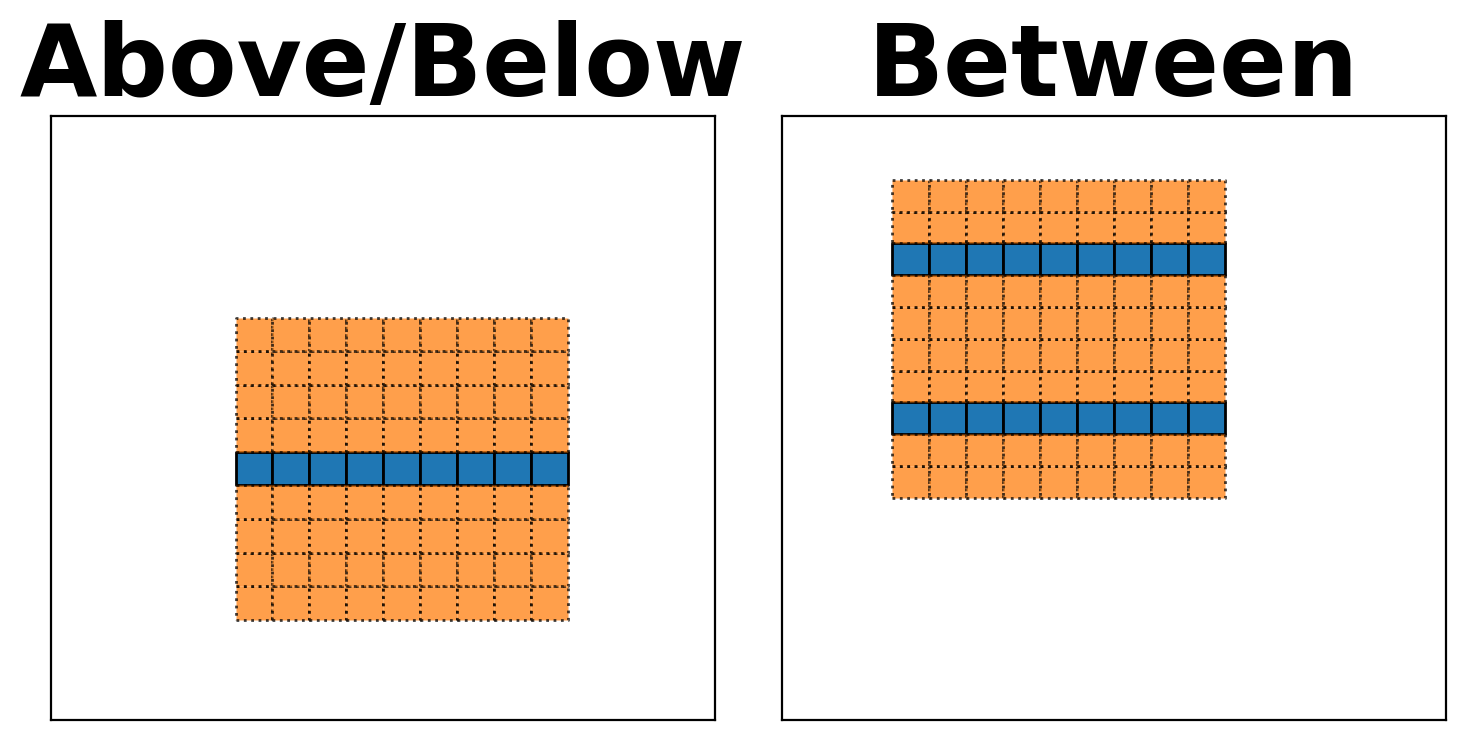

In [35]:
length = 9
above_below_start = 5
above_below_height = 7
between_start = 3
between_lower_height = 9
between_higher_height = 14

fig = plt.figure(figsize=(9, 4), dpi=200)
fig.subplots_adjust(wspace=0.1, hspace=0.125)

bg_color = 'white'
title_font_size = 36

above_below_ax = plt.subplot(1, 2, 1)
above_below_ax.set_title('Above/Below', fontsize=title_font_size, fontweight='bold')

refernece = create_grid(above_below_start, above_below_start + length, above_below_height, above_below_height + 1)
visualize_objects(refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  above_below_ax, bg_color=bg_color)

above_target_grid = create_grid(above_below_start, above_below_start + length, above_below_height + 1, above_below_height + 5, 1)
above_patches, above_colors = create_patches_and_colors(above_target_grid, 
                                                        ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize])
add_patches_to_ax(above_below_ax, above_patches, above_colors, 
                  bg_color=bg_color, linestyle=':')

below_target_grid = create_grid(above_below_start, above_below_start + length, above_below_height - 4, above_below_height, 1)
below_patches, below_colors = create_patches_and_colors(below_target_grid, 
                                                        ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize])
add_patches_to_ax(above_below_ax, below_patches, below_colors, 
                  bg_color=bg_color, linestyle=':')


between_ax = plt.subplot(1, 2, 2)
between_ax.set_title('Between', fontsize=title_font_size, fontweight='bold')

higher_refernece = create_grid(between_start, between_start + length, between_higher_height, between_higher_height + 1)
visualize_objects(higher_refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  between_ax, bg_color=bg_color)

lower_refernece = create_grid(between_start, between_start + length, between_lower_height, between_lower_height + 1)
visualize_objects(lower_refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  between_ax, bg_color=bg_color)

between_above_target_grid = create_grid(between_start, between_start + length, between_higher_height + 1, between_higher_height + 3, 1)
between_above_patches, between_above_colors = create_patches_and_colors(
    between_above_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_above_patches, between_above_colors, 
                  bg_color=bg_color, linestyle=':')

between_target_grid = create_grid(between_start, between_start + length, between_lower_height + 1, between_higher_height, 1)
between_patches, between_colors = create_patches_and_colors(
    between_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_patches, between_colors, 
                  bg_color=bg_color, linestyle=':')

between_below_target_grid = create_grid(between_start, between_start + length, between_lower_height - 2, between_lower_height, 1)
between_below_patches, between_below_colors = create_patches_and_colors(
    between_below_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_below_patches, between_below_colors, 
                  bg_color=bg_color, linestyle=':')

save_plot(f'exp1_target_grid_stimuli_{bg_color}_background.pdf')

plt.show()

In [23]:
one_obj_dataset = ONE_OR_TWO_DATASETS[ObjectGeneratorWithoutSize, False]
two_obj_dataset = ONE_OR_TWO_DATASETS[ObjectGeneratorWithoutSize, True]

Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/exp1_example_stimuli_white_background.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:exp1-example-stimuli-white-background}
% \vspace{-0.2in}
\end{figure}


Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{figures/exp1_example_stimuli_white_background.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:exp1-example-stimuli-white-background}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



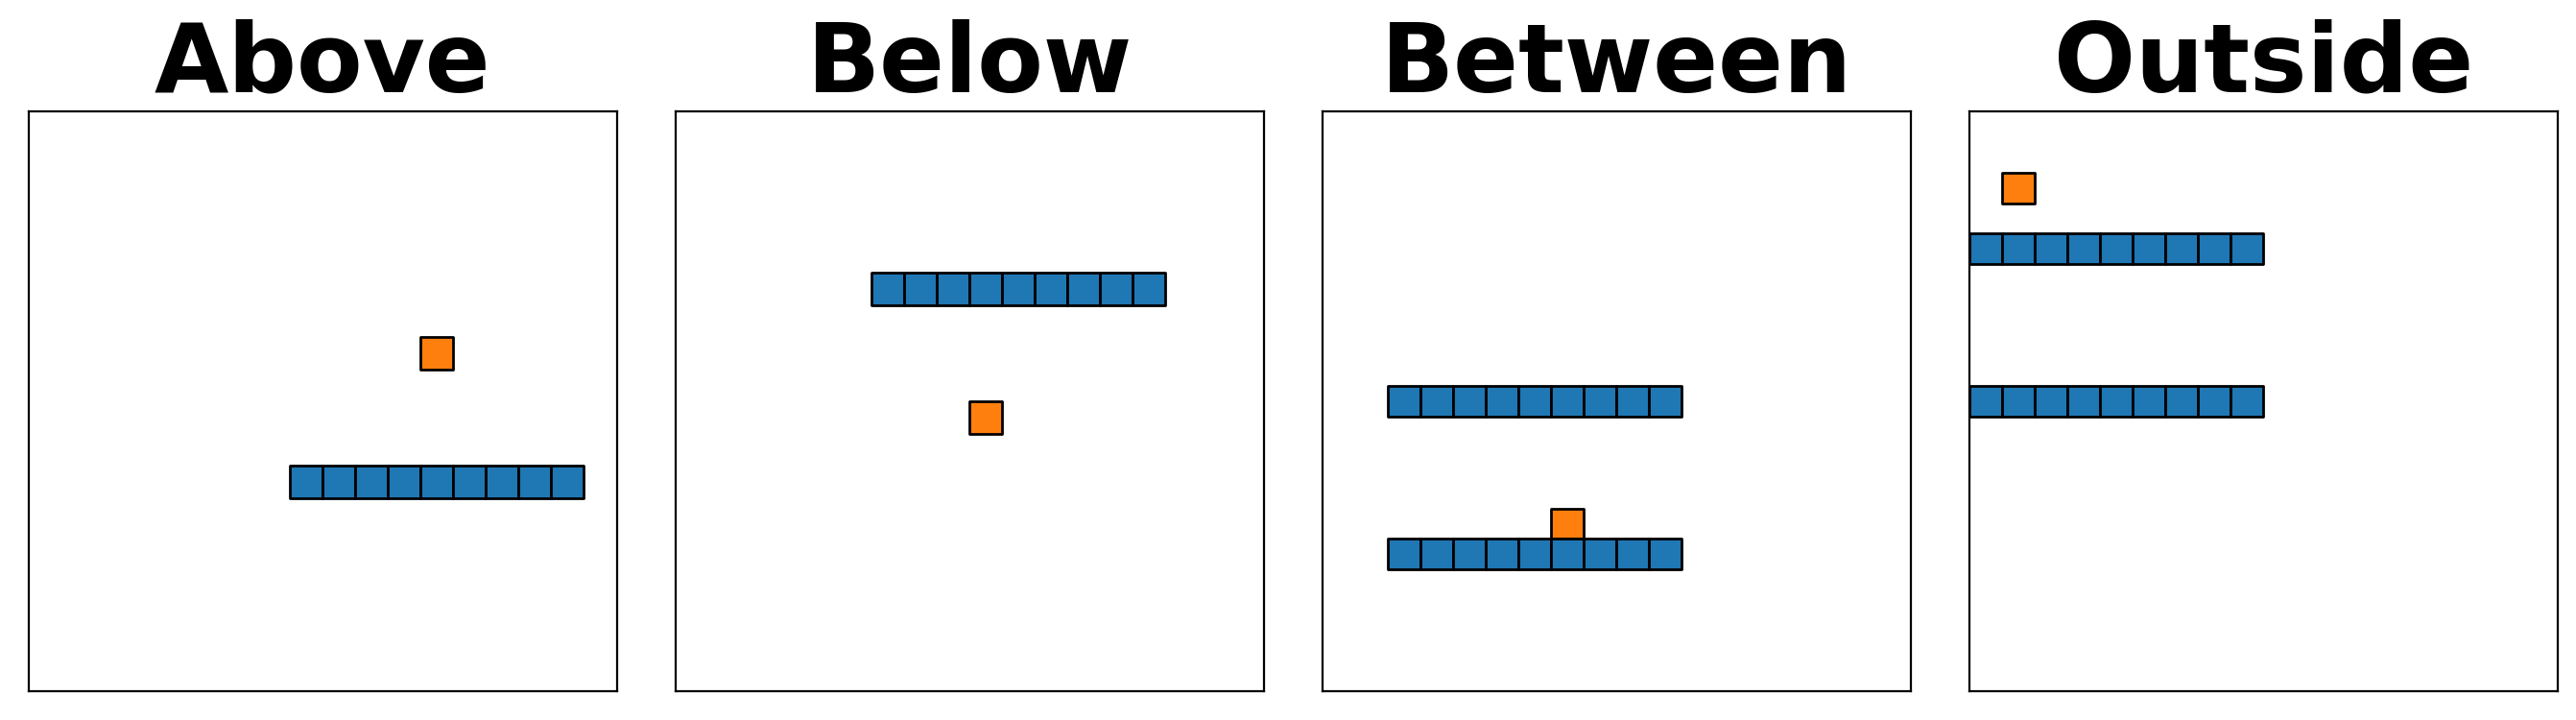

In [34]:
above_below_c_0_idx = 100
above_below_c_1_idx = 2700
between_c_0_idx = 29
between_c_1_idx = 0

fig = plt.figure(figsize=(17, 4), dpi=200)
fig.subplots_adjust(wspace=0.1, hspace=0.125)

bg_color = 'white'
title_font_size = 36

above_below_c0_ax = plt.subplot(1, 4, 1)
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_0_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  ax=above_below_c0_ax, bg_color=bg_color)
above_below_c0_ax.set_title('Above', fontsize=title_font_size, fontweight='bold')

above_below_c1_ax = plt.subplot(1, 4, 2)
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  ax=above_below_c1_ax, bg_color=bg_color)
above_below_c1_ax.set_title('Below', fontsize=title_font_size, fontweight='bold')


between_c0_ax = plt.subplot(1, 4, 3)
visualize_objects(two_obj_dataset.get_training_dataset()[between_c_0_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  ax=between_c0_ax, bg_color=bg_color)
between_c0_ax.set_title('Between', fontsize=title_font_size, fontweight='bold')

between_c1_ax = plt.subplot(1, 4, 4)
visualize_objects(two_obj_dataset.get_training_dataset()[between_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  ax=between_c1_ax, bg_color=bg_color)
between_c1_ax.set_title('Outside', fontsize=title_font_size, fontweight='bold')


save_plot(f'exp1_example_stimuli_{bg_color}_background.pdf')

plt.show()

Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{figures/exp1_stimuli_combined.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:exp1-stimuli-combined}
% \vspace{-0.2in}
\end{figure}


Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{figures/exp1_stimuli_combined.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:exp1-stimuli-combined}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



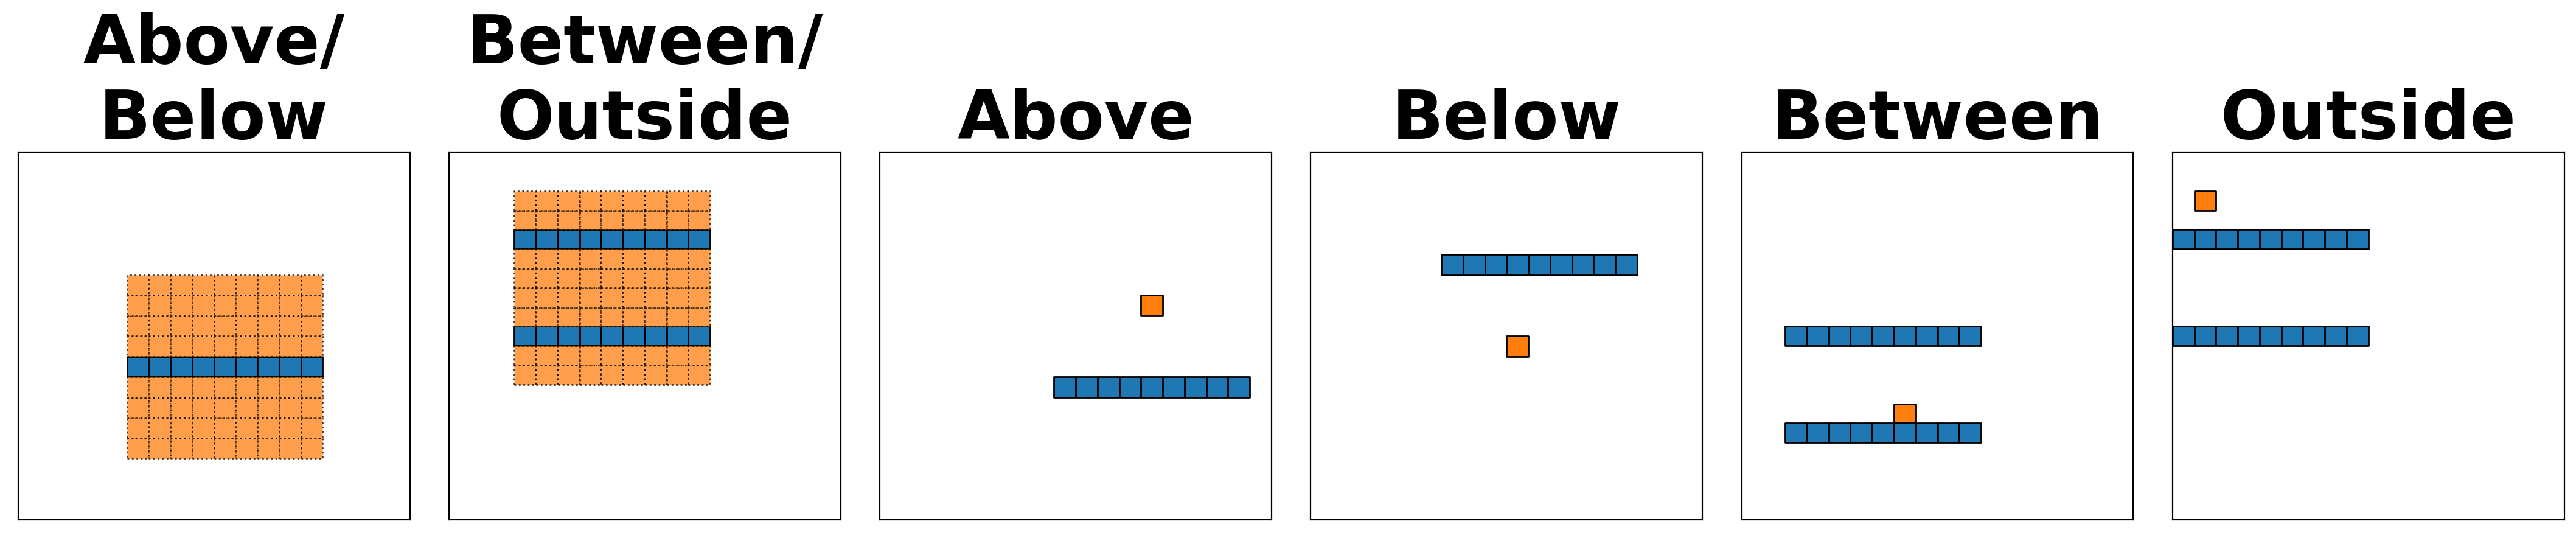

In [33]:
length = 9
above_below_start = 5
above_below_height = 7
between_start = 3
between_lower_height = 9
between_higher_height = 14

fig = plt.figure(figsize=(27, 4), dpi=200)
fig.subplots_adjust(wspace=0.1, hspace=0.125)

title_font_size = 40
bg_color = 'white'

above_below_ax = plt.subplot(1, 6, 1)
above_below_ax.set_title('Above/\nBelow', fontsize=title_font_size, fontweight='bold')

refernece = create_grid(above_below_start, above_below_start + length, above_below_height, above_below_height + 1)
visualize_objects(refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  above_below_ax, bg_color=bg_color)

above_target_grid = create_grid(above_below_start, above_below_start + length, above_below_height + 1, above_below_height + 5, 1)
above_patches, above_colors = create_patches_and_colors(above_target_grid, 
                                                        ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize])
add_patches_to_ax(above_below_ax, above_patches, above_colors, 
                  bg_color=bg_color, linestyle=':')

below_target_grid = create_grid(above_below_start, above_below_start + length, above_below_height - 4, above_below_height, 1)
below_patches, below_colors = create_patches_and_colors(below_target_grid, 
                                                        ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize])
add_patches_to_ax(above_below_ax, below_patches, below_colors, 
                  bg_color=bg_color, linestyle=':')


between_ax = plt.subplot(1, 6, 2)
between_ax.set_title('Between/\nOutside', fontsize=title_font_size, fontweight='bold')

higher_refernece = create_grid(between_start, between_start + length, between_higher_height, between_higher_height + 1)
visualize_objects(higher_refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  between_ax, bg_color=bg_color)

lower_refernece = create_grid(between_start, between_start + length, between_lower_height, between_lower_height + 1)
visualize_objects(lower_refernece, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  between_ax, bg_color=bg_color)

between_above_target_grid = create_grid(between_start, between_start + length, between_higher_height + 1, between_higher_height + 3, 1)
between_above_patches, between_above_colors = create_patches_and_colors(
    between_above_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_above_patches, between_above_colors, 
                  bg_color=bg_color, linestyle=':')

between_target_grid = create_grid(between_start, between_start + length, between_lower_height + 1, between_higher_height, 1)
between_patches, between_colors = create_patches_and_colors(
    between_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_patches, between_colors, 
                  bg_color=bg_color, linestyle=':')

between_below_target_grid = create_grid(between_start, between_start + length, between_lower_height - 2, between_lower_height, 1)
between_below_patches, between_below_colors = create_patches_and_colors(
    between_below_target_grid, ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize])
add_patches_to_ax(between_ax, between_below_patches, between_below_colors, 
                  bg_color=bg_color, linestyle=':')

above_below_c0_ax = plt.subplot(1, 6, 3)
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_0_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  ax=above_below_c0_ax, bg_color=bg_color)
above_below_c0_ax.set_title('Above', fontsize=title_font_size, fontweight='bold')

above_below_c1_ax = plt.subplot(1, 6, 4)
visualize_objects(one_obj_dataset.get_training_dataset()[above_below_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[False][ObjectGeneratorWithoutSize], 
                  ax=above_below_c1_ax, bg_color=bg_color)
above_below_c1_ax.set_title('Below', fontsize=title_font_size, fontweight='bold')


between_c0_ax = plt.subplot(1, 6, 5)
visualize_objects(two_obj_dataset.get_training_dataset()[between_c_0_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  ax=between_c0_ax, bg_color=bg_color)
between_c0_ax.set_title('Between', fontsize=title_font_size, fontweight='bold')

between_c1_ax = plt.subplot(1, 6, 6)
visualize_objects(two_obj_dataset.get_training_dataset()[between_c_1_idx][0], 
                  ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize], 
                  ax=between_c1_ax, bg_color=bg_color)
between_c1_ax.set_title('Outside', fontsize=title_font_size, fontweight='bold')


save_plot(f'exp1_stimuli_combined.pdf')

plt.show()

In [138]:
one_obj_dataset.train_dataset.objects[2500]

tensor([[ 9.,  3.,  0.,  1.],
        [ 2.,  6.,  1.,  0.],
        [ 3.,  6.,  1.,  0.],
        [ 4.,  6.,  1.,  0.],
        [ 5.,  6.,  1.,  0.],
        [ 6.,  6.,  1.,  0.],
        [ 7.,  6.,  1.,  0.],
        [ 8.,  6.,  1.,  0.],
        [ 9.,  6.,  1.,  0.],
        [10.,  6.,  1.,  0.]])

In [98]:
ONE_OR_TWO_QUINN_FAUX_GENERATORS[True][ObjectGeneratorWithoutSize].field_generators['x'].max_coord

18

In [87]:
len(one_obj_dataset.train_reference_object_locations), len(two_obj_dataset.train_reference_object_locations)

(72, 72)

In [16]:
len(one_obj_dataset.test_reference_object_locations), len(two_obj_dataset.test_reference_object_locations)

(9, 9)

In [17]:
len(one_obj_dataset.train_target_locations), len(two_obj_dataset.train_target_locations)

(56, 56)

In [18]:
len(one_obj_dataset.test_target_locations), len(two_obj_dataset.test_target_locations)

(16, 16)

In [25]:
one_obj_dataset._generate_and_split_target_object_locations()

[[array([6, 3]),
  array([4, 0]),
  array([1, 2]),
  array([0, 2]),
  array([5, 3]),
  array([8, 3]),
  array([6, 1]),
  array([3, 2]),
  array([7, 0]),
  array([1, 1]),
  array([2, 2]),
  array([8, 2]),
  array([1, 3]),
  array([6, 0]),
  array([7, 1]),
  array([0, 0]),
  array([4, 3]),
  array([3, 3]),
  array([2, 0]),
  array([7, 3]),
  array([4, 2]),
  array([6, 2]),
  array([0, 3]),
  array([2, 3]),
  array([2, 1]),
  array([5, 0]),
  array([8, 1]),
  array([5, 2]),
  array([1, 7]),
  array([3, 4]),
  array([2, 6]),
  array([0, 7]),
  array([5, 6]),
  array([5, 7]),
  array([2, 7]),
  array([8, 4]),
  array([0, 5]),
  array([4, 4]),
  array([1, 5]),
  array([5, 4]),
  array([5, 5]),
  array([6, 6]),
  array([8, 6]),
  array([4, 6]),
  array([3, 7]),
  array([7, 5]),
  array([7, 6]),
  array([6, 7]),
  array([4, 5]),
  array([7, 4]),
  array([7, 7]),
  array([6, 4]),
  array([3, 6]),
  array([6, 5]),
  array([0, 6]),
  array([1, 6])],
 [array([8, 0]),
  array([7, 2]),
  array([0, 1

In [20]:
(695 + 2802) // 2

1748

In [21]:
dataset.single_reference_height, dataset.bottom_reference_height, dataset.top_reference_height

(4, 2, 6)